In [2]:
import numpy as np
from matplotlib import pyplot as plt

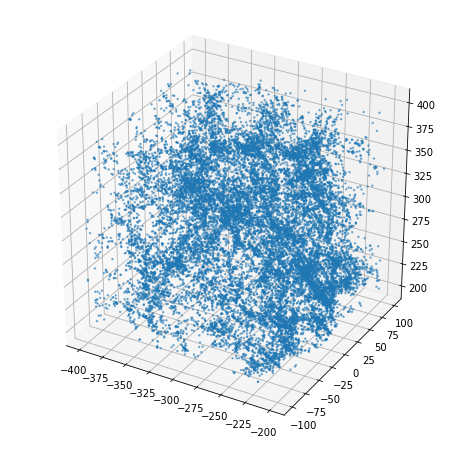

In [4]:
data=np.loadtxt("/Users/mahaixia/DATA/SDSS_DR7/galaxy_DR7/SDSS7_box.txt")
points=data[:,4:7]

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
# axes.set_zlim3d(200, 250)
# axes.set_xlim3d(-150, -100)
# axes.set_ylim3d(50, 100)
axes.scatter(points[:,0], points[:,1], points[:,2], s = 2.0, alpha = 0.5)

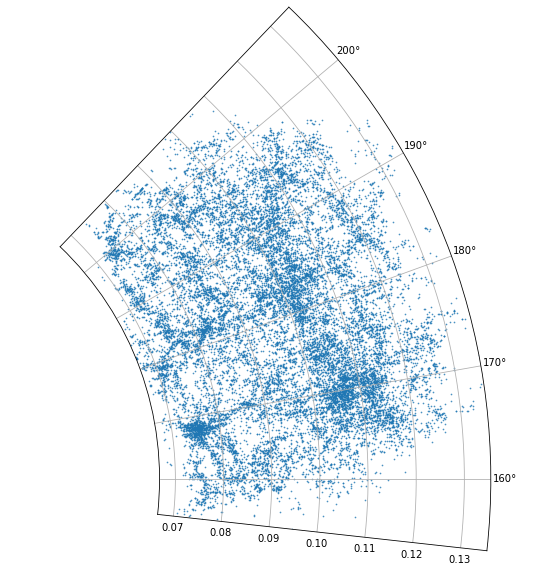

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar')
udeg = 0.017453293  #deg to rad
c = ax.scatter(data[:,1]*udeg, data[:,3], s=0.5, alpha=0.75)

ax.set_thetamax(np.max(data[:,1]))
ax.set_thetamin(np.min(data[:,1]))
ax.set_rorigin(-0)
ax.set_theta_zero_location('W', offset=20)
ax.set_rmax(np.max(data[:,3]))
ax.set_rmin(np.min(data[:,3]))

In [6]:
def plot_sphere(w=0, center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1], ax=None):
    '''
        plot a sphere surface
        Input:
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
                    是椭球的分辨率
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 30)   #np.linspace 取等差数列
    v = np.linspace(0, np.pi, 30)
    x = r[0] * np.outer(np.cos(u), np.sin(v))
    y = r[1] * np.outer(np.sin(u), np.sin(v))
    z = r[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    for i in range(len(x)):
        for j in range(len(x)):
            #[x[i, j], y[i, j], z[i, j]] = [x[i, j], y[i, j], z[i, j]] + center #spherical专用
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation.T) + center

    ax.plot_surface(x, y, z, alpha=0.3, linewidth=0, antialiased=False)

    return ax

In [12]:
from sklearn.mixture import GaussianMixture

n_components= 414
gmm = GaussianMixture(n_components, covariance_type='full')
gmm.fit(points)

GaussianMixture(n_components=414)

In [8]:
def find_fraction(points, center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1]):
    inner = 0.0
    outer = 0.0
    midx = []
    x = points[:,4] - center[0]
    y = points[:,5] - center[1]
    z = points[:,6] - center[2]
    r = r   # 1 sigma球
    for j in range(len(x)):
        [x[j], y[j], z[j]] = np.dot([x[j], y[j], z[j]], np.linalg.inv(rotation))
    for i in range(points.shape[0]):
        distance = np.square(x[i]/r[0]) + np.square(y[i]/r[1]) + np.square(z[i]/r[2])
        if distance > 1.0:
            outer +=1.0
        elif distance < 1.0:
            inner +=1.0
            midx.append(points[i])

    return inner, outer, midx

In [13]:
index = gmm.predict(points)
# figsk = plt.figure(figsize=(8, 8))
# axessk = figsk.add_subplot(111, projection='3d')

member = []
N_member = []
for i in range(n_components):
    covariances = gmm.covariances_[i][:3, :3]
    v, u = np.linalg.eigh(covariances)
    r = np.sqrt(v)
    group = data[np.where(index == i)]
    # plot_sphere(gmm.weights_[i], gmm.means_.T[:3,i], r, u, ax=axessk)
    inner, outer, mlist = find_fraction(group, center=gmm.means_.T[:3,i], r=r, rotation=u)
    member.append(mlist)
    N_member.append(inner)

(array([119., 100.,  79.,  44.,  32.,  19.,   8.,   4.,   5.,   4.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

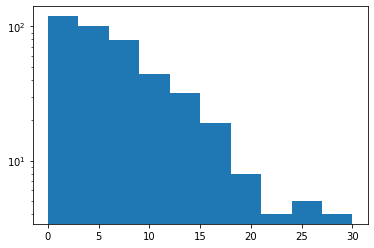

In [14]:
plt.yscale("log")
plt.hist(N_member)

/var/folders/9c/1914lxpx1kz2sxby3kspxwb40000gn/T/ipykernel_17544/905375781.py:2: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.scatter(gmm.means_.T[0,:], gmm.means_.T[1,:], marker='o', c='', edgecolors='r')


Text(0, 0.5, 'Y / Mpc')

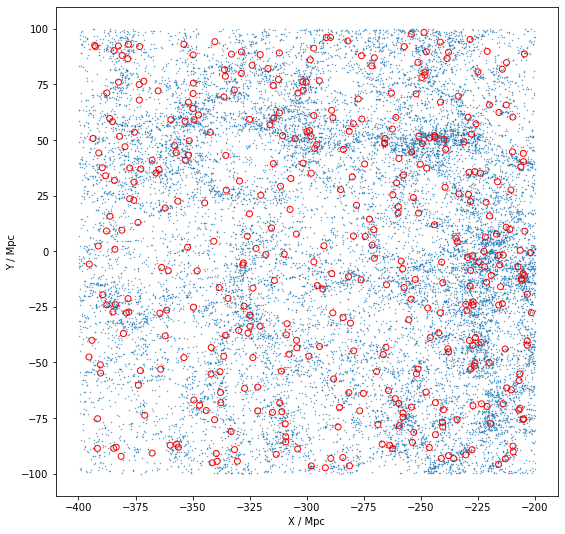

In [27]:
plt.scatter(points[:,0], points[:,1], s=0.2, alpha=0.8)
plt.scatter(gmm.means_.T[0,:], gmm.means_.T[1,:], marker='o', c='', edgecolors='r')
plt.rcParams['figure.figsize'] = (9.0, 9.0)
plt.xlabel("X / Mpc")
plt.ylabel("Y / Mpc")

In [39]:
np.savetxt("Groups_SKGMM.txt",np.c_[np.array(N_member).T, gmm.means_[:, :3]], fmt=' '.join(['%i'] + ['%1.5f']*3))